In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

Selezione numero di persone in ingresso a Dozza

In [5]:
query_mobility = text("SELECT DATE(datefrom) AS date, toid, SUM(datavalue) AS datavalue FROM movements WHERE toid = '08|037|025|000|000' GROUP BY date, toid ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_mobility, connection, chunksize=1000) 
        df_mobility = pd.concat(chunks, ignore_index=True) 
    print(df_mobility)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date                toid  datavalue
0   2019-08-01  08|037|025|000|000      10241
1   2019-08-02  08|037|025|000|000       9752
2   2019-08-03  08|037|025|000|000       9188
3   2019-08-04  08|037|025|000|000       7757
4   2019-08-05  08|037|025|000|000       8431
..         ...                 ...        ...
56  2019-09-26  08|037|025|000|000      10703
57  2019-09-27  08|037|025|000|000       9880
58  2019-09-28  08|037|025|000|000      10000
59  2019-09-29  08|037|025|000|000       9900
60  2019-09-30  08|037|025|000|000      10096

[61 rows x 3 columns]


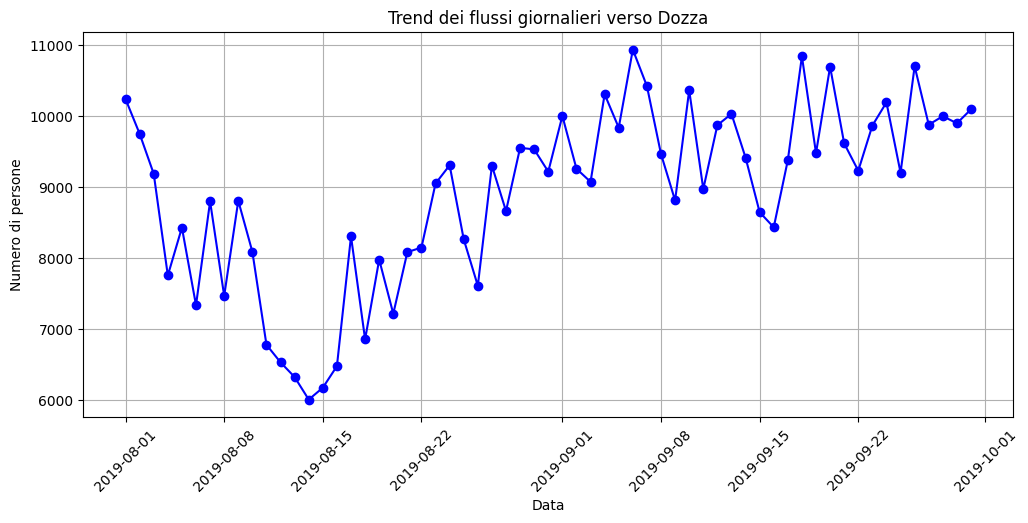

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(df_mobility["date"], df_mobility["datavalue"], marker='o', linestyle='-', color='b')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title("Trend dei flussi giornalieri verso Dozza")
plt.xticks(rotation=45)
plt.grid()
plt.show()

Aggiunta feature weekend

In [8]:
df_mobility["date"] = pd.to_datetime(df_mobility["date"], format="%Y-%m-%d")
df_mobility["weekday"] = df_mobility["date"].dt.weekday
df_mobility["week"] = df_mobility["date"].dt.isocalendar().week - df_mobility["date"].dt.isocalendar().week.min()
df_mobility["weekend"] = df_mobility["weekday"].apply(lambda w: 1 if (w == 5 or w == 6) else 0)
df_mobility

,date,toid,datavalue,weekday,week,weekend
0,2019-08-01,08|037|025|000|000,10241,3,0,0
1,2019-08-02,08|037|025|000|000,9752,4,0,0
2,2019-08-03,08|037|025|000|000,9188,5,0,1
3,2019-08-04,08|037|025|000|000,7757,6,0,1
4,2019-08-05,08|037|025|000|000,8431,0,1,0
...,...,...,...,...,...,...
56,2019-09-26,08|037|025|000|000,10703,3,8,0
57,2019-09-27,08|037|025|000|000,9880,4,8,0
58,2019-09-28,08|037|025|000|000,10000,5,8,1
59,2019-09-29,08|037|025|000|000,9900,6,8,1


Aggiunta feature fenomeni atmosferici ed eventi

In [10]:
query_weather = text("SELECT * FROM weather_data;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_weather, connection, chunksize=1000) 
        df_weather = pd.concat(chunks, ignore_index=True) 
    print(df_weather)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

   localita        data  t_media  t_min  t_max  punto_rugiada  umidita  \
0     Dozza  2019-08-01       29     22     33             16       47   
1     Dozza  2019-08-02       24     19     32             15       56   
2     Dozza  2019-08-03       24     16     31             15       59   
3     Dozza  2019-08-04       26     19     31             16       56   
4     Dozza  2019-08-05       26     20     33             18       61   
..      ...         ...      ...    ...    ...            ...      ...   
56    Dozza  2019-09-26       19     15     25             16       82   
57    Dozza  2019-09-27       21     16     26             16       76   
58    Dozza  2019-09-28       22     18     28             14       62   
59    Dozza  2019-09-29       21     14     27             12       59   
60    Dozza  2019-09-30       22     15     28             14       62   

    visibilita  vento_media  vento_max  raffica  pressione_slm  \
0           21            8         13       

In [11]:
query_events = text("SELECT * FROM dozza_eventi;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_events, connection, chunksize=1000) 
        df_events = pd.concat(chunks, ignore_index=True) 
    print(df_events)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          data  evento
0   2019-08-01       0
1   2019-08-02       0
2   2019-08-03       0
3   2019-08-04       0
4   2019-08-05       0
..         ...     ...
56  2019-09-26       0
57  2019-09-27       0
58  2019-09-28       0
59  2019-09-29       0
60  2019-09-30       0

[61 rows x 2 columns]


In [12]:
from sklearn.preprocessing import LabelEncoder
df_mobility["date"] = pd.to_datetime(df_mobility["date"])
df_weather["data"] = pd.to_datetime(df_weather["data"])
df_events["data"] = pd.to_datetime(df_events["data"])

df = df_mobility.merge(df_weather, left_on ="date", right_on="data", how="left")
df.drop(columns=["data"], inplace=True, errors = "ignore")

df = df.merge(df_events, left_on="date", right_on="data", how="left")
df.drop(columns=["data"], inplace=True, errors = "ignore")

le = LabelEncoder()
df['fenomeni'] = le.fit_transform(df['fenomeni'])
df['fenomeni'] = df['fenomeni'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(columns=['toid', 'localita','t_media', 't_min', 't_max', 'punto_rugiada', 'umidita', 'visibilita', 'vento_media','vento_max','raffica', 'pressione_slm', 'pressione_media', 'pioggia'], errors='ignore')
print(df)

         date  datavalue  weekday  week  weekend  fenomeni  evento
0  2019-08-01      10241        3     0        0         0       0
1  2019-08-02       9752        4     0        0         1       0
2  2019-08-03       9188        5     0        1         0       0
3  2019-08-04       7757        6     0        1         0       0
4  2019-08-05       8431        0     1        0         0       0
..        ...        ...      ...   ...      ...       ...     ...
56 2019-09-26      10703        3     8        0         1       0
57 2019-09-27       9880        4     8        0         0       0
58 2019-09-28      10000        5     8        1         0       0
59 2019-09-29       9900        6     8        1         0       0
60 2019-09-30      10096        0     9        0         0       0

[61 rows x 7 columns]


Aggiunta feature persone in ingresso a Bologna e Imola il giorno precedente

In [14]:
query_bologna = text("SELECT DATE(datefrom) AS date, SUM(datavalue) AS datavalue FROM movements WHERE toid LIKE '08|037|006%' GROUP BY date ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_bologna, connection, chunksize=1000) 
        df_bologna = pd.concat(chunks, ignore_index=True) 
    print(df_bologna)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  datavalue
0   2019-08-01     562915
1   2019-08-02     524811
2   2019-08-03     405302
3   2019-08-04     313369
4   2019-08-05     465981
..         ...        ...
56  2019-09-26     801625
57  2019-09-27     798166
58  2019-09-28     679888
59  2019-09-29     547388
60  2019-09-30     785489

[61 rows x 2 columns]


In [15]:
query_imola = text("SELECT DATE(datefrom) AS date, SUM(datavalue) AS datavalue FROM movements WHERE toid LIKE '08|037|032%' GROUP BY date ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_imola, connection, chunksize=1000) 
        df_imola = pd.concat(chunks, ignore_index=True) 
    print(df_imola)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  datavalue
0   2019-08-01      85571
1   2019-08-02      81407
2   2019-08-03      70136
3   2019-08-04      55002
4   2019-08-05      75086
..         ...        ...
56  2019-09-26      97325
57  2019-09-27      92172
58  2019-09-28      85540
59  2019-09-29      68718
60  2019-09-30      96508

[61 rows x 2 columns]


In [16]:
df_bologna = df_bologna.rename(columns={'datavalue': 'bologna'})
df_imola = df_imola.rename(columns={'datavalue': 'imola'})

df_bologna["date"] = pd.to_datetime(df_bologna["date"])
df_imola["date"] = pd.to_datetime(df_imola["date"])

df = pd.merge(df, df_bologna, on='date', how='left')
df= pd.merge(df, df_imola, on='date', how='left')
df = df.drop(columns=['date'], errors='ignore')

#sposto di una riga per fare riferimento al giorno precedente
df["bologna"] = df["bologna"].shift(1).fillna(0)
df["imola"] = df["imola"].shift(1).fillna(0)
print(df)

    datavalue  weekday  week  weekend  fenomeni  evento   bologna    imola
0       10241        3     0        0         0       0       0.0      0.0
1        9752        4     0        0         1       0  562915.0  85571.0
2        9188        5     0        1         0       0  524811.0  81407.0
3        7757        6     0        1         0       0  405302.0  70136.0
4        8431        0     1        0         0       0  313369.0  55002.0
..        ...      ...   ...      ...       ...     ...       ...      ...
56      10703        3     8        0         1       0  807756.0  96977.0
57       9880        4     8        0         0       0  801625.0  97325.0
58      10000        5     8        1         0       0  798166.0  92172.0
59       9900        6     8        1         0       0  679888.0  85540.0
60      10096        0     9        0         0       0  547388.0  68718.0

[61 rows x 8 columns]


In [17]:
X = df.drop(['datavalue'],axis='columns')
y = df['datavalue']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Gradient Boosting 

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#divido X e Y in old(senza features) e new (con features)
X_train_old = X_train.drop(columns=['weekend', 'fenomeni', 'evento', 'bologna', 'imola'], errors = 'ignore')
X_test_old = X_test.drop(columns=['weekend', 'fenomeni', 'evento', 'bologna', 'imola'], errors = 'ignore')

y_train_scaled = np.log1p(y_train)
y_test_scaled = np.log1p(y_test)
scaler = MinMaxScaler()

X_train_scaled_new = scaler.fit_transform(X_train)
X_test_scaled_new = scaler.transform(X_test)
X_train_scaled_old = scaler.fit_transform(X_train_old)
X_test_scaled_old = scaler.transform(X_test_old)


GB without Features

In [22]:
Model_GB = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=Model_GB, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled_old, y_train_scaled)
print("Migliori parametri trovati:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Migliori parametri trovati: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


*** Gradient Boosting - senza features ***
MAE = 968.4909061643733
MAPE = 11.36264704525383 %


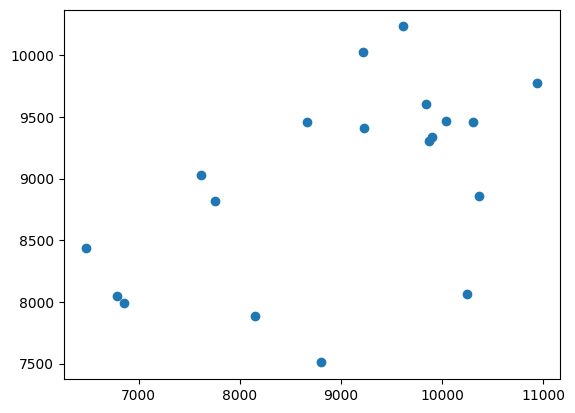

In [23]:
print("*** Gradient Boosting - senza features ***")
best_model = grid_search.best_estimator_
y_pred_old = best_model.predict(X_test_scaled_old)

y_pred_old =np.expm1(y_pred_old)
y_test =np.expm1(y_test_scaled)
print('MAE =', mean_absolute_error(y_test, y_pred_old))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_old)*100,'%')
MAPE_GB_old = mean_absolute_percentage_error(y_test, y_pred_old)*100
plt.scatter(y_test, y_pred_old)
plt.show()

GB with Features

In [25]:
Model_GB = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(estimator=Model_GB, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled_new, y_train_scaled)
print("Migliori parametri trovati:", grid_search.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Migliori parametri trovati: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}


*** Gradient Boosting - con features ***
MAE = 820.3230579457174
MAPE = 9.480861383509565 %


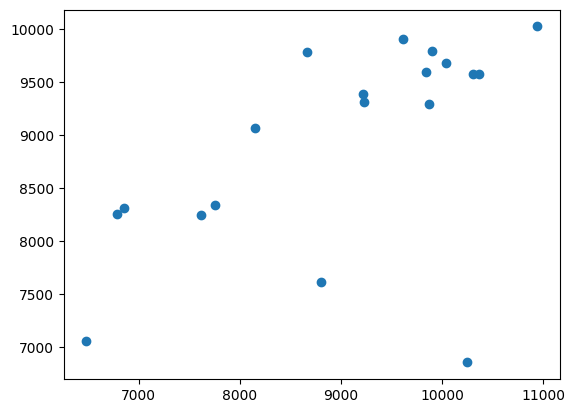

In [26]:
print("*** Gradient Boosting - con features ***")
best_model = grid_search.best_estimator_
y_pred_new = best_model.predict(X_test_scaled_new)

y_pred_new =np.expm1(y_pred_new)
y_test =np.expm1(y_test_scaled)
print('MAE =', mean_absolute_error(y_test, y_pred_new))
print('MAPE =',mean_absolute_percentage_error(y_test, y_pred_new)*100,'%')
MAPE_GB_new = mean_absolute_percentage_error(y_test, y_pred_new)*100
plt.scatter(y_test, y_pred_new)
plt.show()

Compare

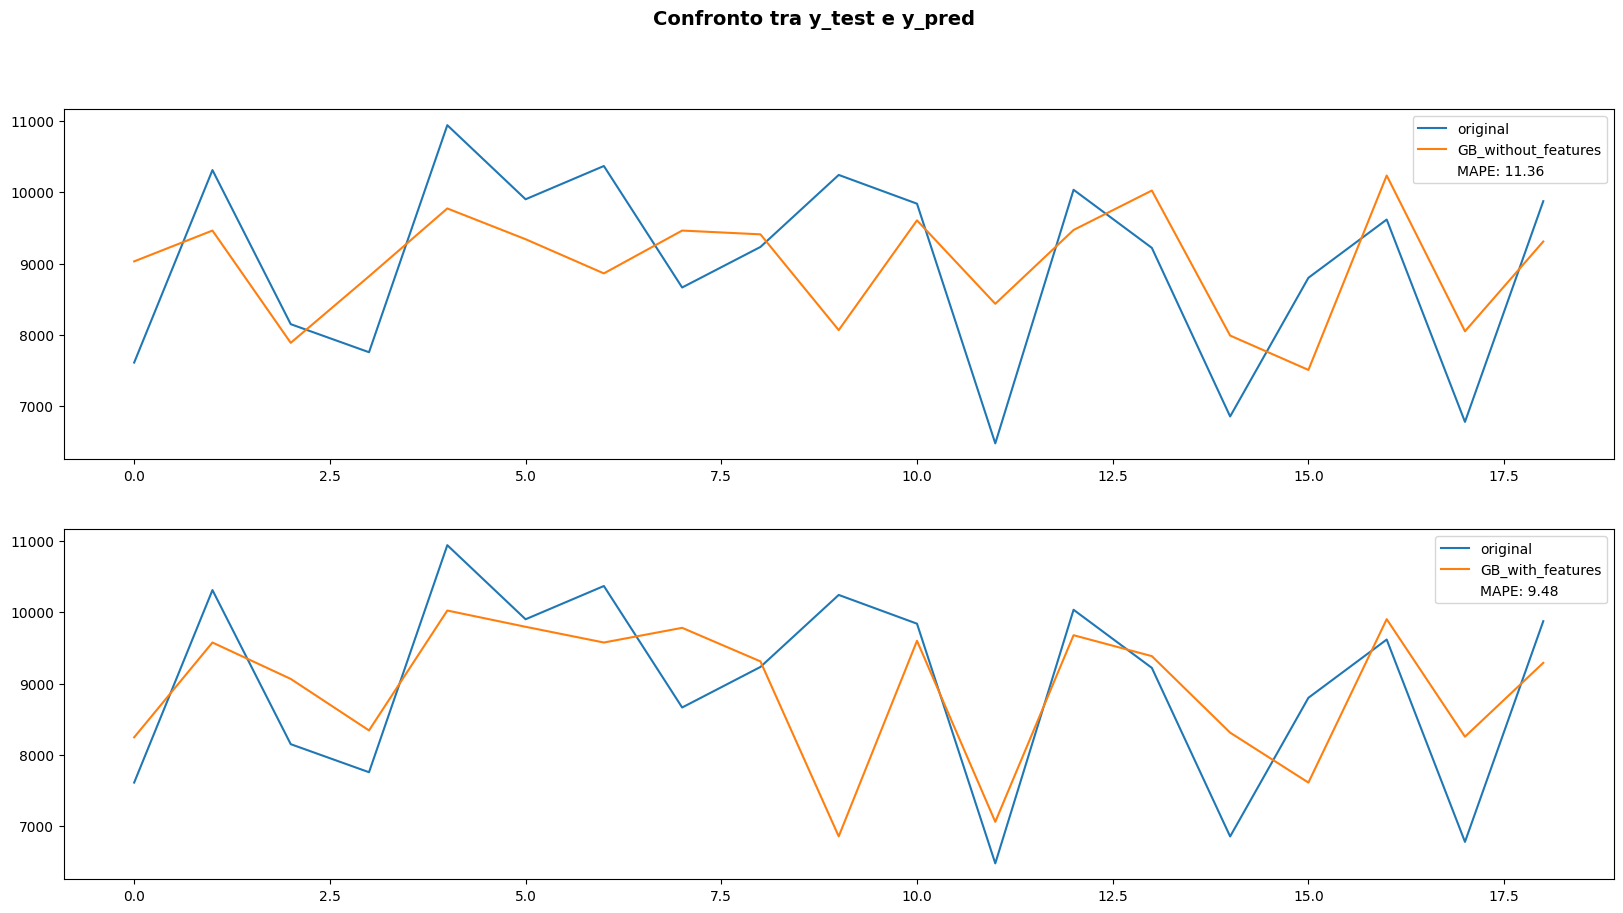

In [28]:
n_records = min(len(y_test), len(y_pred_old))
indici = np.arange(n_records)
fig, axes = plt.subplots(2, 1, figsize=(20, 10)) 
fig.suptitle('Confronto tra y_test e y_pred', fontsize=14, fontweight='bold')
axes[0].plot(indici, y_test[:n_records], label='original')
axes[0].plot(indici, y_pred_old[:n_records],label='GB_without_features')
axes[0].legend()
axes[0].plot([], [], ' ', label=f'MAPE: {MAPE_GB_old:.2f}')
axes[0].legend()
axes[1].plot(indici, y_test[:n_records], label='original')
axes[1].plot(indici, y_pred_new[:n_records],label='GB_with_features')
axes[1].plot([], [], ' ', label=f'MAPE: {MAPE_GB_new:.2f}')
axes[1].legend()
plt.show()